In [338]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Data Visualization

In [359]:
nq_1hr = pd.read_csv("archive/NQ_in_1_hour.csv")
nq_1hr.head()

,datetime,symbol,open,high,low,close,volume
0,2024-01-01 23:00:00,CME_MINI:NQ1!,17019.00,17037.00,17013.75,17029.50,4582.0
1,2024-01-02 00:00:00,CME_MINI:NQ1!,17030.00,17030.75,17018.50,17027.00,2270.0
2,2024-01-02 01:00:00,CME_MINI:NQ1!,17026.75,17038.50,17010.75,17014.50,5255.0
3,2024-01-02 02:00:00,CME_MINI:NQ1!,17014.50,17019.00,17001.00,17008.25,3541.0
4,2024-01-02 03:00:00,CME_MINI:NQ1!,17008.25,17013.00,17002.25,17007.50,2024.0


In [360]:
nq_1hr.isna().sum()

datetime    0
symbol      0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [361]:
nq_1hr.describe()

,open,high,low,close,volume
count,10504.000000,10504.000000,10504.000000,10504.000000,10504.000000
mean,20389.144707,20418.951066,20357.336205,20389.719393,24376.404703
std,2054.416148,2052.119516,2056.860219,2054.588696,30782.500048
min,16385.750000,16395.000000,16334.250000,16385.500000,276.000000
25%,18651.000000,18676.000000,18624.375000,18651.000000,3894.000000
50%,20217.000000,20241.375000,20186.000000,20217.375000,7802.000000
75%,21726.062500,21752.125000,21685.062500,21726.250000,40075.750000
max,25379.000000,25394.000000,25363.250000,25378.750000,215784.000000


In [362]:
nq_1hr.drop(columns=["symbol", "datetime"]).corr()

,open,high,low,close,volume
open,1.000000,0.999811,0.999785,0.999688,-0.091214
high,0.999811,1.000000,0.999600,0.999808,-0.083198
low,0.999785,0.999600,1.000000,0.999808,-0.101532
close,0.999688,0.999808,0.999808,1.000000,-0.092779
volume,-0.091214,-0.083198,-0.101532,-0.092779,1.000000


In [363]:
nq_1hr['datetime'] = pd.to_datetime(nq_1hr['datetime'])

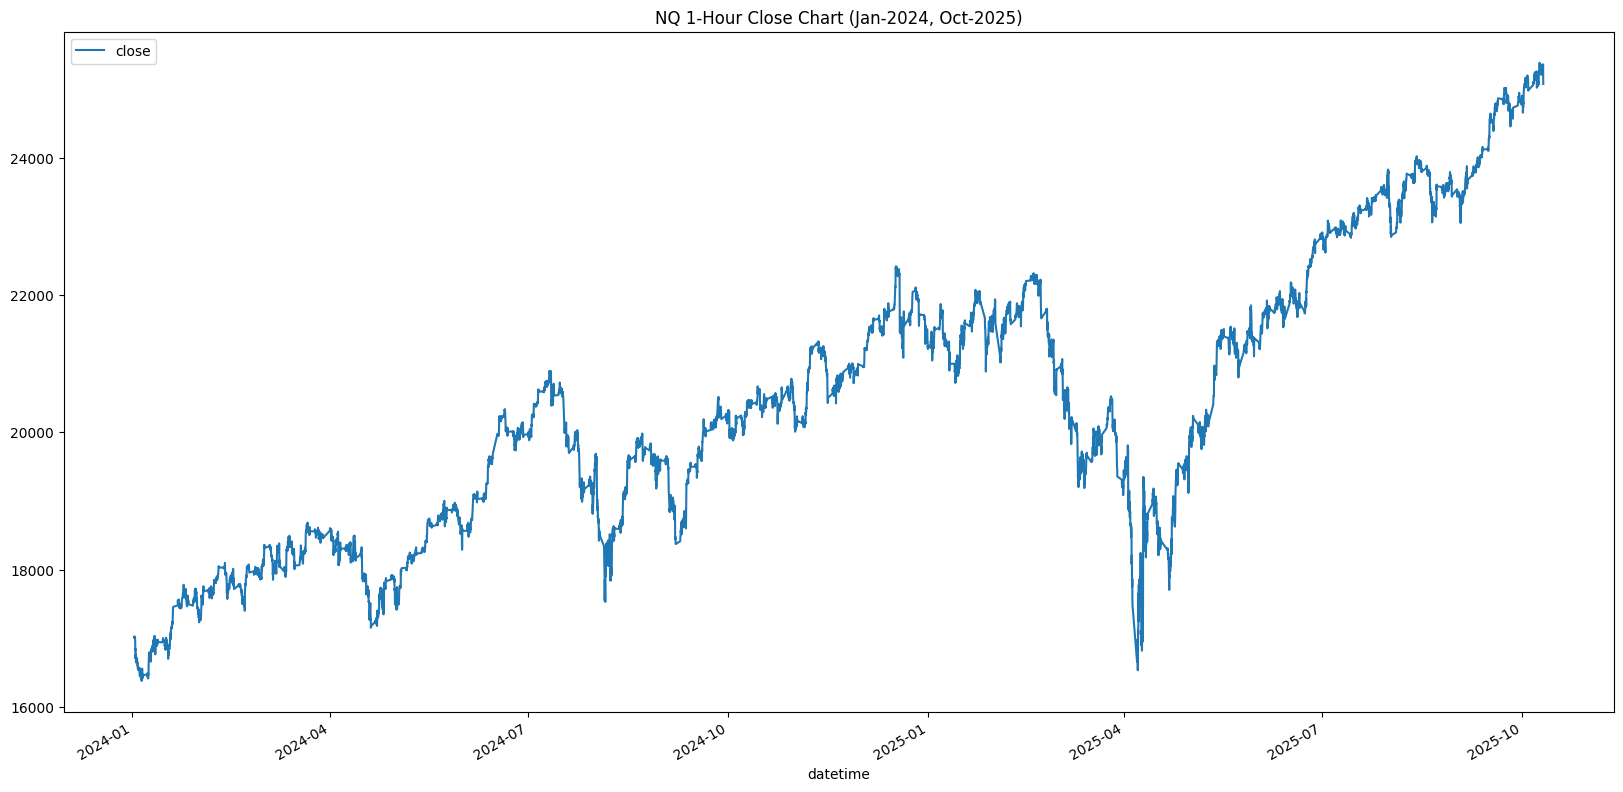

In [364]:
nq_1hr.plot(title="NQ 1-Hour Close Chart (Jan-2024, Oct-2025)",figsize=(20,10), x="datetime", y="close")
plt.show()

### For this Regression I will attempt to predict the next hours closing price from the Open/High/Low/Close/Volume of the previous hour.

In [365]:
def lagged_features(data: pd.DataFrame, columns: list):
    for column in columns:
        if column in data.columns:
            data[column+'_lag1'] = data[column].shift(1)
            data[column+'_lag2'] = data[column].shift(2)
            data[column+'_lag3'] = data[column].shift(3)
    data = data.dropna()

    return data

In [366]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error


def lm_train_cv(X, y):
    lm = LinearRegression()
    tscv = TimeSeriesSplit(n_splits=5)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"Fold {i}:")
        lm.fit(X.iloc[train_index], y.iloc[train_index])

        y_hat = lm.predict(X.iloc[test_index])
        mae = mean_absolute_error(y.iloc[test_index], y_hat)
        rmse = root_mean_squared_error(y.iloc[test_index], y_hat)
        r2 = r2_score(y.iloc[test_index], y_hat)
        r2_adj = 1.0 - (((1-r2) * (len(train_index)-1))/(len(train_index)-len(X.columns)-1))
        print("MAE: ", mae)
        print("RMSE:", rmse)
        print("R_Squared: ", r2)
        print("R_Squared_adj: ", r2_adj)
        plt.plot(y.index[test_index], y.iloc[test_index], label="Actual", color="red")
        plt.plot(y.index[test_index], y_hat, label="Predicted", color="blue")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.show()
    

In [367]:
nq_1hr = lagged_features(nq_1hr, ['open','high','low','volume', 'close'])
X = nq_1hr.drop(columns=['open','high','low','volume', 'close', 'symbol', 'datetime']).reset_index(drop=True)
y = nq_1hr["close"]

Fold 0:
MAE:  25.980114439211363
RMSE: 42.51783561767846
R_Squared:  0.9980959965766495
R_Squared_adj:  0.9980795354519519


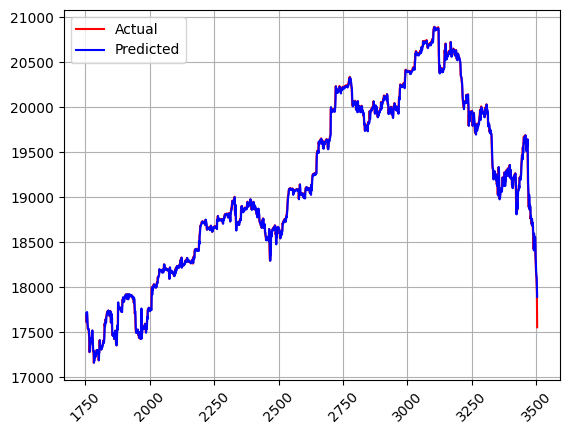

Fold 1:
MAE:  31.693893899904047
RMSE: 48.38892001641651
R_Squared:  0.99603033375723
R_Squared_adj:  0.9960132476758408


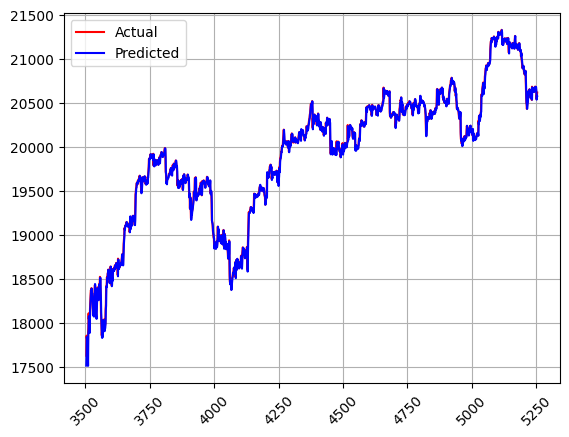

Fold 2:
MAE:  33.5942545569298
RMSE: 55.267738586834255
R_Squared:  0.9883348827575106
R_Squared_adj:  0.9883014583528043


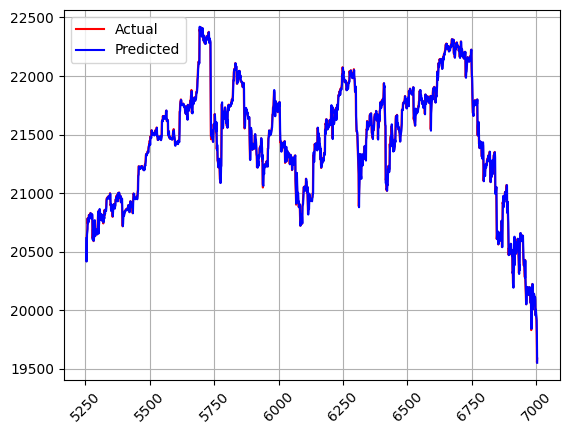

Fold 3:
MAE:  47.761718689029614
RMSE: 83.24969594707458
R_Squared:  0.9959932871517282
R_Squared_adj:  0.9959846829008013


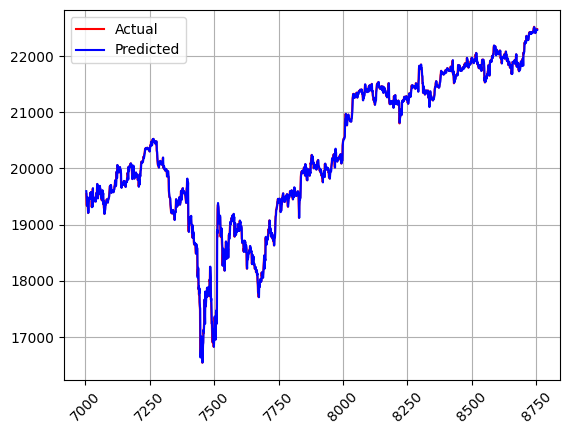

Fold 4:
MAE:  24.774627767525967
RMSE: 38.88753399113553
R_Squared:  0.9972442164693254
R_Squared_adj:  0.9972394841564507


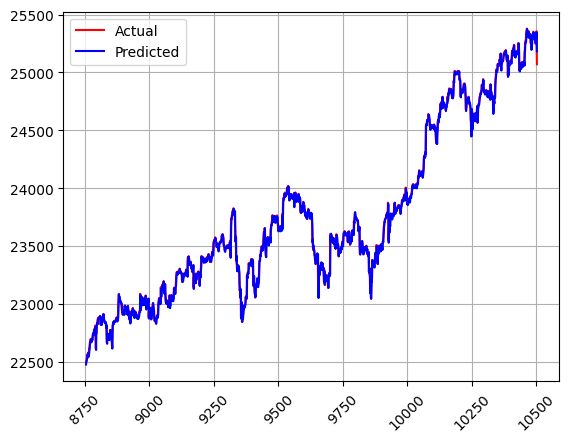

In [368]:
lm_train_cv(X, y)

## Experiment 2: Adding time based features

In [369]:
nq_1hr["year"] = nq_1hr.datetime.dt.year
nq_1hr["month"] = nq_1hr.datetime.dt.month
nq_1hr["day"] = nq_1hr.datetime.dt.day
nq_1hr["dayofweek"] = nq_1hr.datetime.dt.dayofweek
nq_1hr["hour"] = nq_1hr.datetime.dt.hour
nq_1hr["quarter"] = nq_1hr.datetime.dt.quarter
nq_1hr = nq_1hr.set_index(nq_1hr["datetime"]).drop(columns="datetime")

<Axes: xlabel='datetime'>

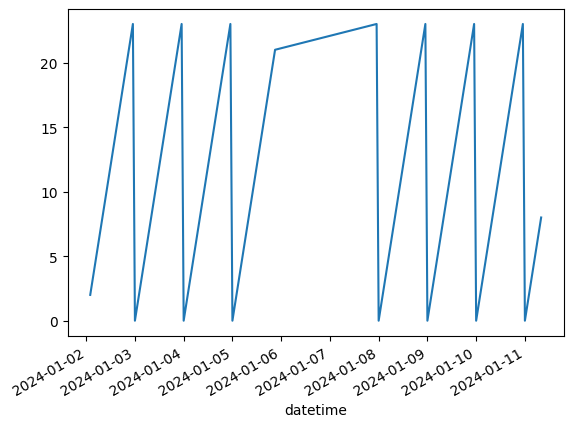

In [370]:
nq_1hr[:168]["hour"].plot()

Since all of the time based features are cyclical, they must be encoded so that they have the same distance from the largest to smallest

In [372]:
def encode_cyclical(data: pd.DataFrame, columns: list):

    for column in columns:
        if column in data.columns:
            data[column + "_sin"] = np.sin(2 * np.pi * data[column]/np.max(data[column]))
            data[column + "_cos"] = np.cos(2 * np.pi * data[column]/np.max(data[column]))
            data = data.drop(columns=column)
        else:
            print(f"Could not encode column: {column}")
    return data

In [373]:
nq_1hr = encode_cyclical(nq_1hr, ["year", "month", "day", "hour", "quarter", "dayofweek"])

In [ ]:
X = nq_1hr.drop(columns=['open','high','low','volume', 'close', 'symbol'])
y = nq_1hr["close"]

Fold 0:
MAE:  39.34066606214886
RMSE: 52.681261453154654
R_Squared:  0.9970769398043621
R_Squared_adj:  0.9970311344501646


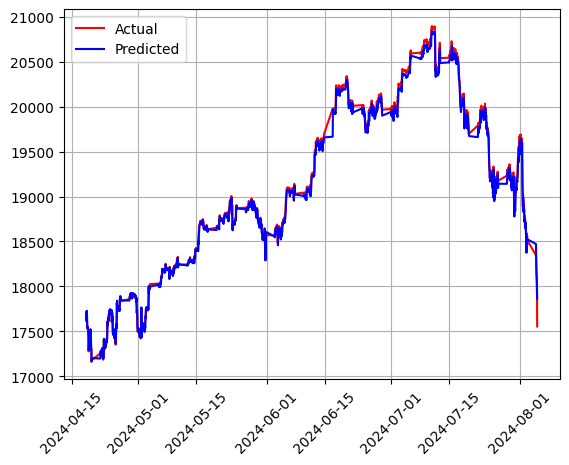

Fold 1:
MAE:  33.078514839484434
RMSE: 49.38891408101261
R_Squared:  0.9958645660347084
R_Squared_adj:  0.9958324161017793


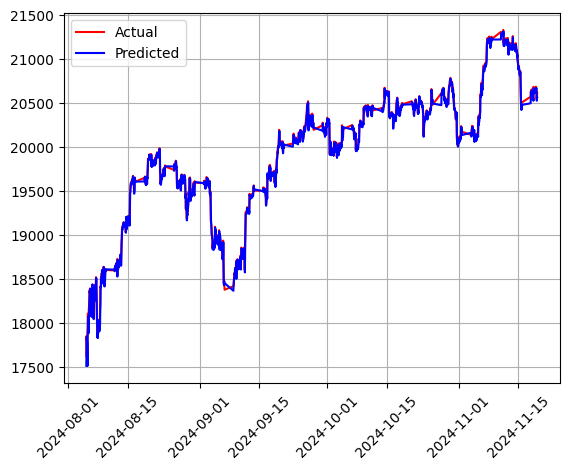

Fold 2:
MAE:  34.039347407604986
RMSE: 55.396488885318526
R_Squared:  0.9882804699393182
R_Squared_adj:  0.988219886498453


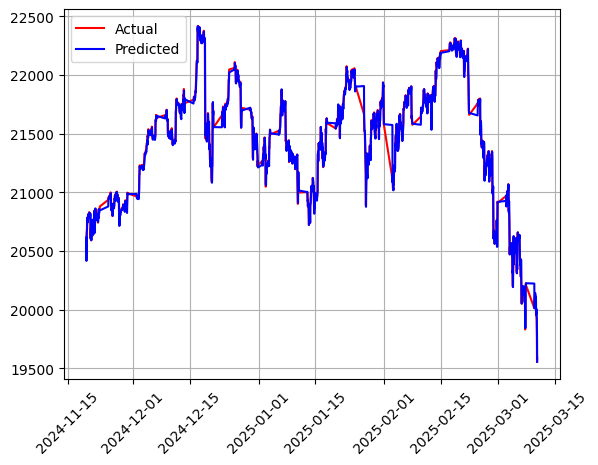

Fold 3:
MAE:  47.878173654646595
RMSE: 83.25214311081719
R_Squared:  0.9959930515898703
R_Squared_adj:  0.9959775363730233


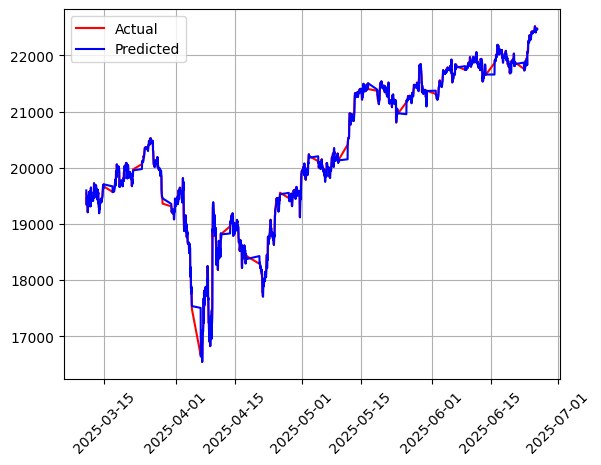

Fold 4:
MAE:  25.26043027665734
RMSE: 39.150033371473896
R_Squared:  0.9972068866147338
R_Squared_adj:  0.9971982411875411


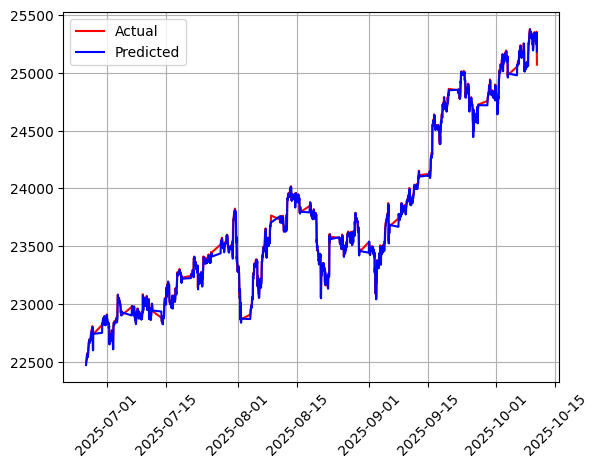

In [379]:
lm_train_cv(X,y)

## Experiment 3: Seasonal and Trend Decomposition using LOESS

In [380]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [381]:
def encode_seasonality(data: pd.DataFrame, column: str, period: int):

    if column in data.columns:
        stl = STL(endog=data[column], period=period)
        res = stl.fit()
        adf = adfuller(res.resid)
        data[column + "_trend"] = res.trend
        data[column + "_season"] = res.seasonal
        data[column + "_residual"] = res.resid
        if adf[1] > 0.5:
            print(f"P-Value > 0.5: No stationarity found for {column}")
        else:
            print(f"P-Value < 0.5: Stationarity found for {column}")
    else:
        print(f"Could not encode column: {column}")

    return data


In [382]:
nq_1hr = encode_seasonality(nq_1hr, "close", 24)

P-Value < 0.5: Stationarity found for close


In [383]:
X = nq_1hr.drop(columns=['open','high','low','volume', 'close', 'symbol'])
y = nq_1hr["close"]

Fold 0:
MAE:  8.75193758734635e-12
RMSE: 9.577927401338428e-12
R_Squared:  1.0
R_Squared_adj:  1.0


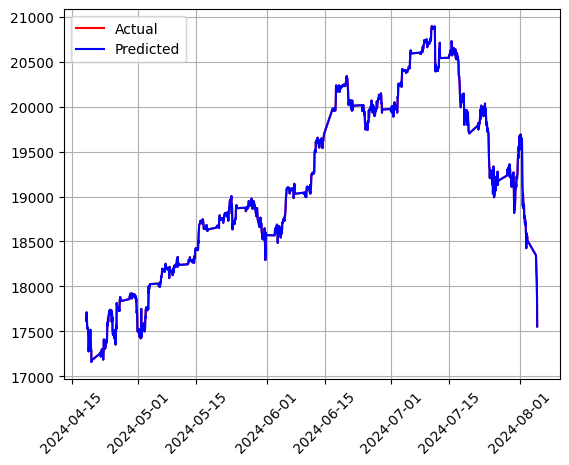

Fold 1:
MAE:  1.4115357771515847e-12
RMSE: 2.461259460459752e-12
R_Squared:  1.0
R_Squared_adj:  1.0


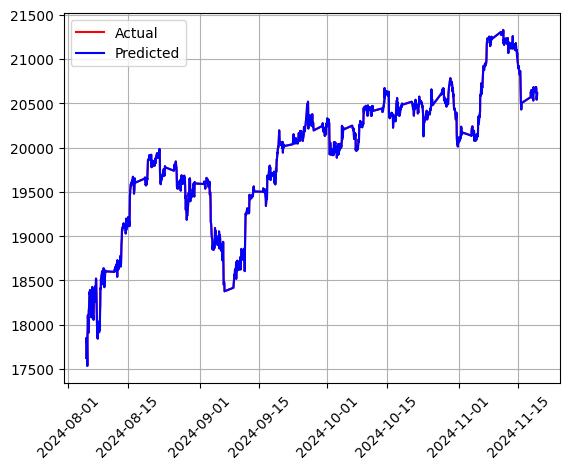

Fold 2:
MAE:  4.030880518257618e-12
RMSE: 5.37563359343632e-12
R_Squared:  1.0
R_Squared_adj:  1.0


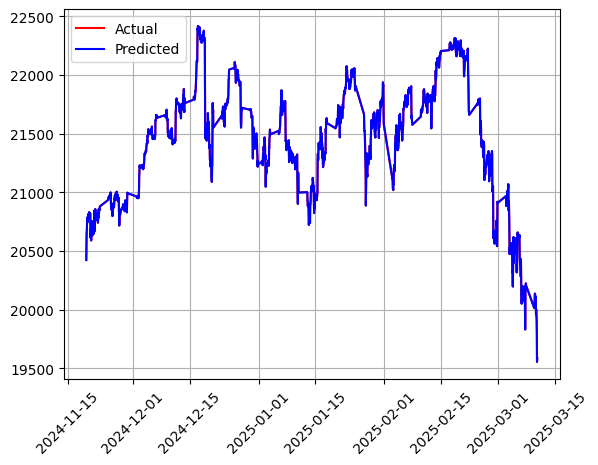

Fold 3:
MAE:  1.3127906381019524e-11
RMSE: 1.6320820246818533e-11
R_Squared:  1.0
R_Squared_adj:  1.0


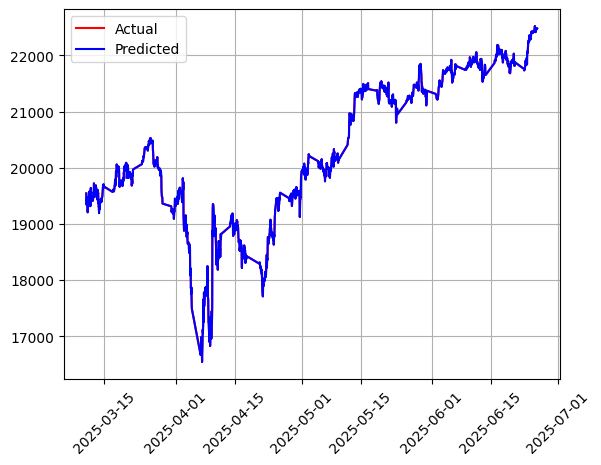

Fold 4:
MAE:  5.305212523256029e-12
RMSE: 6.76311904018643e-12
R_Squared:  1.0
R_Squared_adj:  1.0


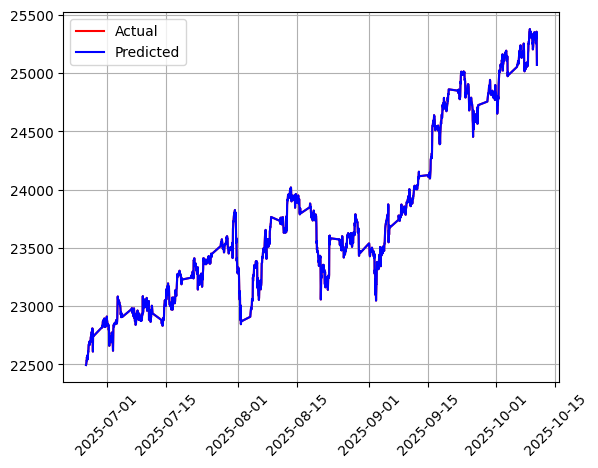

In [384]:
lm_train_cv(X,y)